referensi https://www.kaggle.com/cast42/feature-selection-and-elastic-net

In [1]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score, KFold
from itertools import product
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import time

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
#import dataset
df = pd.read_csv('/home/jupyter-17523142/Rama/Dataset/dataset_rama.csv')
X = df.drop(['No', 'Mango Cultivars', 'Vit C (mg/100g)', 'TA (mg/100g)', 'SSC (oBrix)', 'label'], axis = 1)
y_vitc = df.loc[:, 'Vit C (mg/100g)']

# separate dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(
    X, y_vitc, test_size = 0.3, random_state=0)

# Seleksi Fitur Elastic Net

### Cari pasangan nilai alpha dan l1_ratio terbaik

In [3]:
%%time

#define fungsi buat hitung rmse
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


In [4]:
%%time

alphas = [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1]
l1_ratios = [0.5, 0.1, 1, 0.9, 0.8, 0.7, 0.5]

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.63 µs


In [5]:
%%time

#train beberapa model elastic net menggunakan pasangan alphas sm l1 ratio
cv_elastic = [rmse_cv(ElasticNet(alpha = alpha, l1_ratio=l1_ratio, tol=0.9)).mean()
              for (alpha, l1_ratio) in product(alphas, l1_ratios)]

CPU times: user 5min 11s, sys: 8.58 s, total: 5min 20s
Wall time: 13.4 s


Text(0, 0.5, 'rmse')

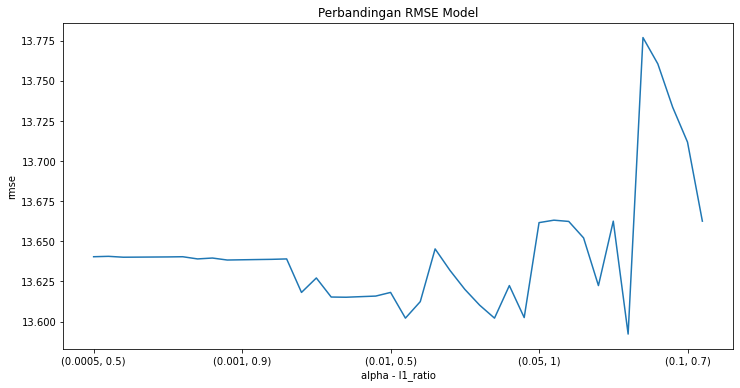

In [6]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))
p_cv_elastic = pd.Series(cv_elastic, index = idx)
p_cv_elastic.plot(title = "Perbandingan RMSE Model")
plt.xlabel("alpha - l1_ratio")
plt.ylabel("rmse")

Dapat dilihat bahwa pasangan nilai alpha sebesar 0.05 dan l1_ratio sebesar 1 mampu menghasilkan nilai RMSE terkecil (sekitar 13.6)

In [7]:
%%time
# bikin elastic net pake rmse paling kecil
elastic = ElasticNet(alpha=0.05, l1_ratio=1, tol=0.9)

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 19.6 µs


In [8]:
%%time

elastic.fit(x_train, y_train)

CPU times: user 51.8 ms, sys: 1.37 ms, total: 53.2 ms
Wall time: 13 ms


ElasticNet(alpha=0.05, l1_ratio=1, tol=0.9)

In [9]:
dir(elastic)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_preprocess_data',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_intercept',
 '_validate_data',
 'alpha',
 'coef_',
 'copy_X',
 'dual_gap_',
 'feature_names_in_',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'l1_ratio',
 'max_iter',
 'n_features_in_',
 'n_iter_',
 'normalize',
 'path',
 'positive',
 'precompute',
 'predict',
 'random_state',
 'score',
 'selection',
 'set_params',
 

In [10]:
#ambil koefisien dari model elastic
coef = pd.Series(elastic.coef_, index = x_train.columns)

In [10]:
coef

999.9     36.146395
1000.3     0.505321
1000.7     0.291640
1001.1     0.000000
1001.4     0.163907
            ...    
2490.6     0.025751
2493       0.036197
2495.4     0.055177
2497.8     0.020544
2500.2     0.026002
Length: 1557, dtype: float64

In [11]:
print("Elastic Net mengambil " + str(sum(coef != 0)) + " variabel dan menghilangkan " +  str(sum(coef == 0)) + " variabel")

Elastic Net mengambil 196 variabel dan menghilangkan 1361 variabel


In [12]:
#buat data frame yg nyimpan fitur terpilih beserta coef-nya
df_coef = pd.DataFrame(coef, columns=["Coeficients"])
df_fitur_terpilih = df_coef[(df_coef != 0).all(1)]

In [13]:
df_fitur_terpilih.nlargest(196, columns="Coeficients")

,Coeficients
999.9,36.146395
1000.3,0.505321
1000.7,0.291640
1019.2,0.204651
1001.4,0.163907
...,...
1393.2,-0.337994
1388,-0.342913
1390.2,-0.343675
1391.7,-0.344533


In [14]:
print("Fitur yang dipilih : " + str(df_fitur_terpilih.index.tolist()))
print("Total fitur yang dipilih : " + str(len(df_fitur_terpilih.index)))

Fitur yang dipilih : ['999.9', '1000.3', '1000.7', '1001.4', '1001.8', '1008.1', '1010.8', '1015.6', '1017.2', '1019.2', '1025.6', '1029.3', '1032.6', '1319.5', '1320.1', '1320.8', '1321.5', '1322.1', '1322.8', '1323.5', '1324.2', '1324.9', '1325.5', '1326.2', '1326.9', '1327.6', '1328.2', '1328.9', '1329.6', '1330.3', '1331', '1331.7', '1332.3', '1333', '1333.7', '1334.4', '1335.1', '1335.8', '1336.5', '1337.1', '1337.8', '1338.5', '1339.2', '1339.9', '1340.6', '1341.3', '1342', '1342.7', '1343.4', '1344.1', '1344.8', '1345.5', '1346.2', '1346.9', '1347.6', '1348.3', '1349', '1349.7', '1350.4', '1351.1', '1351.8', '1352.5', '1353.2', '1353.9', '1354.6', '1355.3', '1356', '1356.7', '1357.5', '1358.2', '1358.9', '1359.6', '1360.3', '1361', '1361.7', '1362.4', '1363.2', '1363.9', '1364.6', '1365.3', '1366', '1366.8', '1367.5', '1368.2', '1368.9', '1369.6', '1370.4', '1371.1', '1371.8', '1372.5', '1373.3', '1374', '1374.7', '1375.5', '1376.2', '1376.9', '1377.6', '1378.4', '1379.1', '1379

In [15]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# Linear Regression

In [16]:
%%time

#tentukan metode scoring yang digunakan
metrics = {'rmse': 'neg_root_mean_squared_error',
               'mse': 'neg_mean_squared_error',
               'mae': 'neg_mean_absolute_error',
               'r2': 'r2'} 

n_feat = range(1, 101)
min_mse = 1000
min_rmse = 1000
min_mae = 1000

for nfeat in n_feat:
    print("==================================================")
    start_time = time.time()

    #ambil n fitur input hasil seleksi fitur Elastic Net
    x_train_selected = x_train[df_fitur_terpilih.nlargest(196, columns="Coeficients").iloc[0:nfeat, 0].index]
    x_test_selected = x_test[df_fitur_terpilih.nlargest(196, columns="Coeficients").iloc[0:nfeat, 0].index]

    #Create a Linear Regression
    lr_model = LinearRegression()

    #Train the model using the training sets
    lr_model.fit(x_train_selected, y_train)
    y_pred_lr = lr_model.predict(x_test_selected)

    #hitung score model dari data train
    scores = cross_validate(lr_model, x_train_selected, y_train, scoring=metrics, cv=cv, return_train_score=True)

    print("MSE model Linear Regression data Train dengan " + str(nfeat) + " fitur: " 
          + str(abs(round(scores['train_mse'].mean(), 2))))
    print("RMSE model Linear Regression data Train dengan " + str(nfeat) + " fitur:"
          + str(abs(round(scores['train_rmse'].mean(), 2))))
    print("MAE model Linear Regression data Train dengan " + str(nfeat) + " fitur:"
          + str(abs(round(scores['train_mae'].mean(), 2))))
    print("R2 model Linear Regression data Train dengan " + str(nfeat) + " fitur:"
          + str(abs(round(scores['train_r2'].mean(), 2))))
    print("-------------------------")
    print("MSE model Linear Regression data Test dengan " + str(nfeat) + " fitur:" 
          + str(abs(round(mean_squared_error(y_test, y_pred_lr), 2))))
    print("RMSE model Linear Regression data Test dengan " + str(nfeat) + " fitur:" 
          + str(abs(round(mean_squared_error(y_test, y_pred_lr, squared = False), 2))))
    print("MAE model Linear Regression data Test dengan " + str(nfeat) + " fitur:" 
          + str(abs(round(mean_absolute_error(y_test, y_pred_lr), 2))))
    print("R2 model Linear Regression data Test dengan " + str(nfeat) + " fitur:" 
          + str(abs(round(r2_score(y_test, y_pred_lr), 2))))
    print(" ")
    
    if(abs(round(mean_squared_error(y_test, y_pred_lr), 2) < min_mse)):
        min_mse = abs(round(mean_squared_error(y_test, y_pred_lr), 2))

    if(abs(round(mean_squared_error(y_test, y_pred_lr, squared = False), 2) < min_rmse)):
        min_rmse = abs(round(mean_squared_error(y_test, y_pred_lr, squared = False), 2))

    if(abs(round(mean_absolute_error(y_test, y_pred_lr), 2) < min_mae)):
        min_mae = abs(round(mean_absolute_error(y_test, y_pred_lr), 2))

    end_time = time.time()
    print("Total waktu: ", end_time - start_time)

print("====Nilai Performa Tertinggi====")
print("Nilai MSE model terendah: " + str(min_mse))
print("Nilai RMSE model terendah: " + str(min_rmse))
print("Nilai MAE model terendah: " + str(min_mae))

MSE model Linear Regression data Train dengan 1 fitur: 188.59
RMSE model Linear Regression data Train dengan 1 fitur:13.73
MAE model Linear Regression data Train dengan 1 fitur:11.07
R2 model Linear Regression data Train dengan 1 fitur:0.02
-------------------------
MSE model Linear Regression data Test dengan 1 fitur:183.34
RMSE model Linear Regression data Test dengan 1 fitur:13.54
MAE model Linear Regression data Test dengan 1 fitur:10.4
R2 model Linear Regression data Test dengan 1 fitur:0.06
 
Total waktu:  0.40520644187927246
MSE model Linear Regression data Train dengan 2 fitur: 148.04
RMSE model Linear Regression data Train dengan 2 fitur:12.17
MAE model Linear Regression data Train dengan 2 fitur:9.78
R2 model Linear Regression data Train dengan 2 fitur:0.23
-------------------------
MSE model Linear Regression data Test dengan 2 fitur:173.04
RMSE model Linear Regression data Test dengan 2 fitur:13.15
MAE model Linear Regression data Test dengan 2 fitur:11.14
R2 model Linear R

# Random Forest Regression n = 100

In [17]:
%%time

#tentukan metode scoring yang digunakan
metrics = {'rmse': 'neg_root_mean_squared_error',
               'mse': 'neg_mean_squared_error',
               'mae': 'neg_mean_absolute_error',
               'r2': 'r2'} 

n_feat = range(1, 101)
n_trees = [100]
min_mse = 1000
min_rmse = 1000
min_mae = 1000

for nfeat in n_feat:
    for ntrees in n_trees:
        print("==================================================")
        start_time = time.time()

        #ambil n fitur input hasil seleksi fitur Elastic net
        x_train_selected = x_train[df_fitur_terpilih.nlargest(196, columns="Coeficients").iloc[0:nfeat, 0].index]
        x_test_selected = x_test[df_fitur_terpilih.nlargest(196, columns="Coeficients").iloc[0:nfeat, 0].index]

        #Create a Random Forest Regression
        rfg_model = RandomForestRegressor(n_estimators=ntrees)
        
        #Train the model using the training sets
        rfg_model.fit(x_train_selected, y_train)
        y_pred_rfg=rfg_model.predict(x_test_selected)

        #hitung score model dari data train
        scores = cross_validate(rfg_model, x_train_selected, y_train, scoring=metrics, cv=cv, return_train_score=True)

        print("MSE model Random Forest Regression data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:"
              + str(abs(round(scores['train_mse'].mean(), 2))))
        print("RMSE model Random Forest Regression data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:"
              + str(abs(round(scores['train_rmse'].mean(), 2))))
        print("MAE model Random Forest Regression data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:"
              + str(abs(round(scores['train_mae'].mean(), 2))))
        print("R2 model Random Forest Regression data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:"
              + str(abs(round(scores['train_r2'].mean(), 2))))
        print("-------------------------")
        print("MSE model Random Forest Regression data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(abs(round(mean_squared_error(y_test, y_pred_rfg), 2))))
        print("RMSE model Random Forest Regression data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(abs(round(mean_squared_error(y_test, y_pred_rfg, squared = False), 2))))
        print("MAE model Random Forest Regression data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(abs(round(mean_absolute_error(y_test, y_pred_rfg), 2))))
        print("R2 model Random Forest Regression data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(abs(round(r2_score(y_test, y_pred_rfg), 2))))
        print(" ")

        if(abs(round(mean_squared_error(y_test, y_pred_rfg), 2) < min_mse)):
            min_mse = abs(round(mean_squared_error(y_test, y_pred_rfg), 2))

        if(abs(round(mean_squared_error(y_test, y_pred_rfg, squared = False), 2) < min_rmse)):
            min_rmse = abs(round(mean_squared_error(y_test, y_pred_rfg, squared = False), 2))

        if(abs(round(mean_absolute_error(y_test, y_pred_rfg), 2) < min_mae)):
            min_mae = abs(round(mean_absolute_error(y_test, y_pred_rfg), 2))

        end_time = time.time()
        print("Total waktu: ", end_time - start_time)

print("====Nilai Performa Tertinggi====")
print("Nilai MSE model terendah: " + str(min_mse))
print("Nilai RMSE model terendah: " + str(min_rmse))
print("Nilai MAE model terendah: " + str(min_mae))

MSE model Random Forest Regression data Train dengan 1 fitur dan 100 trees:44.68
RMSE model Random Forest Regression data Train dengan 1 fitur dan 100 trees:6.68
MAE model Random Forest Regression data Train dengan 1 fitur dan 100 trees:5.2
R2 model Random Forest Regression data Train dengan 1 fitur dan 100 trees:0.77
-------------------------
MSE model Random Forest Regression data Test dengan 1 fitur dan 100 trees:248.45
RMSE model Random Forest Regression data Test dengan 1 fitur dan 100 trees:15.76
MAE model Random Forest Regression data Test dengan 1 fitur dan 100 trees:12.41
R2 model Random Forest Regression data Test dengan 1 fitur dan 100 trees:0.44
 
Total waktu:  1.7519655227661133
MSE model Random Forest Regression data Train dengan 2 fitur dan 100 trees:43.85
RMSE model Random Forest Regression data Train dengan 2 fitur dan 100 trees:6.61
MAE model Random Forest Regression data Train dengan 2 fitur dan 100 trees:5.11
R2 model Random Forest Regression data Train dengan 2 fit

# RFG n = 150

In [18]:
%%time

#tentukan metode scoring yang digunakan
metrics = {'rmse': 'neg_root_mean_squared_error',
               'mse': 'neg_mean_squared_error',
               'mae': 'neg_mean_absolute_error',
               'r2': 'r2'} 

n_feat = range(1, 101)
n_trees = [150]
min_mse = 1000
min_rmse = 1000
min_mae = 1000
max_r2 = 0

for nfeat in n_feat:
    for ntrees in n_trees:
        print("==================================================")
        start_time = time.time()

        #ambil n fitur input hasil seleksi fitur Elastic net
        x_train_selected = x_train[df_fitur_terpilih.nlargest(196, columns="Coeficients").iloc[0:nfeat, 0].index]
        x_test_selected = x_test[df_fitur_terpilih.nlargest(196, columns="Coeficients").iloc[0:nfeat, 0].index]

        #Create a Random Forest Regression
        rfg_model = RandomForestRegressor(n_estimators=ntrees)
        
        #Train the model using the training sets
        rfg_model.fit(x_train_selected, y_train)
        y_pred_rfg=rfg_model.predict(x_test_selected)

        #hitung score model dari data train
        scores = cross_validate(rfg_model, x_train_selected, y_train, scoring=metrics, cv=cv, return_train_score=True)

        print("MSE model Random Forest Regression data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:"
              + str(abs(round(scores['train_mse'].mean(), 2))))
        print("RMSE model Random Forest Regression data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:"
              + str(abs(round(scores['train_rmse'].mean(), 2))))
        print("MAE model Random Forest Regression data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:"
              + str(abs(round(scores['train_mae'].mean(), 2))))
        print("R2 model Random Forest Regression data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:"
              + str(abs(round(scores['train_r2'].mean(), 2))))
        print("-------------------------")
        print("MSE model Random Forest Regression data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(abs(round(mean_squared_error(y_test, y_pred_rfg), 2))))
        print("RMSE model Random Forest Regression data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(abs(round(mean_squared_error(y_test, y_pred_rfg, squared = False), 2))))
        print("MAE model Random Forest Regression data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(abs(round(mean_absolute_error(y_test, y_pred_rfg), 2))))
        print("R2 model Random Forest Regression data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(abs(round(r2_score(y_test, y_pred_rfg), 2))))
        print(" ")

        if(abs(round(mean_squared_error(y_test, y_pred_rfg), 2) < min_mse)):
            min_mse = abs(round(mean_squared_error(y_test, y_pred_rfg), 2))

        if(abs(round(mean_squared_error(y_test, y_pred_rfg, squared = False), 2) < min_rmse)):
            min_rmse = abs(round(mean_squared_error(y_test, y_pred_rfg, squared = False), 2))

        if(abs(round(mean_absolute_error(y_test, y_pred_rfg), 2) < min_mae)):
            min_mae = abs(round(mean_absolute_error(y_test, y_pred_rfg), 2))
        end_time = time.time()
        print("Total waktu: ", end_time - start_time)

print("====Nilai Performa Tertinggi====")
print("Nilai MSE model terendah: " + str(min_mse))
print("Nilai RMSE model terendah: " + str(min_rmse))
print("Nilai MAE model terendah: " + str(min_mae))

MSE model Random Forest Regression data Train dengan 1 fitur dan 150 trees:44.03
RMSE model Random Forest Regression data Train dengan 1 fitur dan 150 trees:6.63
MAE model Random Forest Regression data Train dengan 1 fitur dan 150 trees:5.15
R2 model Random Forest Regression data Train dengan 1 fitur dan 150 trees:0.77
-------------------------
MSE model Random Forest Regression data Test dengan 1 fitur dan 150 trees:246.22
RMSE model Random Forest Regression data Test dengan 1 fitur dan 150 trees:15.69
MAE model Random Forest Regression data Test dengan 1 fitur dan 150 trees:12.23
R2 model Random Forest Regression data Test dengan 1 fitur dan 150 trees:0.43
 
Total waktu:  2.5236754417419434
MSE model Random Forest Regression data Train dengan 2 fitur dan 150 trees:43.49
RMSE model Random Forest Regression data Train dengan 2 fitur dan 150 trees:6.59
MAE model Random Forest Regression data Train dengan 2 fitur dan 150 trees:5.13
R2 model Random Forest Regression data Train dengan 2 fi

# RFG n = 200

In [19]:
%%time

#tentukan metode scoring yang digunakan
metrics = {'rmse': 'neg_root_mean_squared_error',
               'mse': 'neg_mean_squared_error',
               'mae': 'neg_mean_absolute_error',
               'r2': 'r2'} 

n_feat = range(1, 101)
n_trees = [200]
min_mse = 1000
min_rmse = 1000
min_mae = 1000

for nfeat in n_feat:
    for ntrees in n_trees:
        print("==================================================")
        start_time = time.time()

        #ambil n fitur input hasil seleksi fitur Elastic net
        x_train_selected = x_train[df_fitur_terpilih.nlargest(196, columns="Coeficients").iloc[0:nfeat, 0].index]
        x_test_selected = x_test[df_fitur_terpilih.nlargest(196, columns="Coeficients").iloc[0:nfeat, 0].index]

        #Create a Random Forest Regression
        rfg_model = RandomForestRegressor(n_estimators=ntrees)
        
        #Train the model using the training sets
        rfg_model.fit(x_train_selected, y_train)
        y_pred_rfg=rfg_model.predict(x_test_selected)

        #hitung score model dari data train
        scores = cross_validate(rfg_model, x_train_selected, y_train, scoring=metrics, cv=cv, return_train_score=True)

        print("MSE model Random Forest Regression data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:"
              + str(abs(round(scores['train_mse'].mean(), 2))))
        print("RMSE model Random Forest Regression data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:"
              + str(abs(round(scores['train_rmse'].mean(), 2))))
        print("MAE model Random Forest Regression data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:"
              + str(abs(round(scores['train_mae'].mean(), 2))))
        print("R2 model Random Forest Regression data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:"
              + str(abs(round(scores['train_r2'].mean(), 2))))
        print("-------------------------")
        print("MSE model Random Forest Regression data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(abs(round(mean_squared_error(y_test, y_pred_rfg), 2))))
        print("RMSE model Random Forest Regression data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(abs(round(mean_squared_error(y_test, y_pred_rfg, squared = False), 2))))
        print("MAE model Random Forest Regression data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(abs(round(mean_absolute_error(y_test, y_pred_rfg), 2))))
        print("R2 model Random Forest Regression data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(abs(round(r2_score(y_test, y_pred_rfg), 2))))
        print(" ")

        if(abs(round(mean_squared_error(y_test, y_pred_rfg), 2) < min_mse)):
            min_mse = abs(round(mean_squared_error(y_test, y_pred_rfg), 2))

        if(abs(round(mean_squared_error(y_test, y_pred_rfg, squared = False), 2) < min_rmse)):
            min_rmse = abs(round(mean_squared_error(y_test, y_pred_rfg, squared = False), 2))

        if(abs(round(mean_absolute_error(y_test, y_pred_rfg), 2) < min_mae)):
            min_mae = abs(round(mean_absolute_error(y_test, y_pred_rfg), 2))

        end_time = time.time()
        print("Total waktu: ", end_time - start_time)

print("====Nilai Performa Tertinggi====")
print("Nilai MSE model terendah: " + str(min_mse))
print("Nilai RMSE model terendah: " + str(min_rmse))
print("Nilai MAE model terendah: " + str(min_mae))

MSE model Random Forest Regression data Train dengan 1 fitur dan 200 trees:43.81
RMSE model Random Forest Regression data Train dengan 1 fitur dan 200 trees:6.61
MAE model Random Forest Regression data Train dengan 1 fitur dan 200 trees:5.16
R2 model Random Forest Regression data Train dengan 1 fitur dan 200 trees:0.77
-------------------------
MSE model Random Forest Regression data Test dengan 1 fitur dan 200 trees:245.29
RMSE model Random Forest Regression data Test dengan 1 fitur dan 200 trees:15.66
MAE model Random Forest Regression data Test dengan 1 fitur dan 200 trees:12.28
R2 model Random Forest Regression data Test dengan 1 fitur dan 200 trees:0.42
 
Total waktu:  3.3930649757385254
MSE model Random Forest Regression data Train dengan 2 fitur dan 200 trees:43.2
RMSE model Random Forest Regression data Train dengan 2 fitur dan 200 trees:6.57
MAE model Random Forest Regression data Train dengan 2 fitur dan 200 trees:5.09
R2 model Random Forest Regression data Train dengan 2 fit